# Modeling through Random Forest

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap.umap_ as umap # install "umap-learn" instead of "umap"
from IPython.display import display
#from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics

params = [2, 15, 0.1, 'euclidean'] # Default parameters for umap

## Load Filtered Training Data

In [2]:
train = pd.read_csv('Data/3690_all.tsv', sep = '\t', index_col = [0])
train.index.name = 'r_id'
train.reset_index(inplace = True)
train.head()

,r_id,MGS_LEVEL,TSPAN6,FUCA2,GCLC,SEMA3F,ANKIB1,BAD,CD99,MAD1L1,...,PCBP2-OT1,RP11-557N21.1,CTC-325H20.8,CTD-2021K4.1,RP11-681B3.4,RP11-118G23.3,RP11-624J6.2,RP11-9J18.1,RP11-793J2.1,RP11-419I17.1
0,205_2,2,0.413827,0.374748,0.692236,0.364232,0.616166,0.230769,0.535113,0.454147,...,0.342184,0.142460,0.222006,0.611190,0.658467,0.148492,0.205038,0.139876,0.371926,0.175608
1,251_1,1,0.236678,0.227783,0.243099,0.393270,0.343130,0.262310,0.337588,0.514919,...,0.154700,0.188546,0.293826,0.307780,0.476310,0.147397,0.266822,0.000000,0.276888,0.172579
2,474_3,3,0.187834,0.153301,0.279470,0.455109,0.330394,0.282329,0.174306,0.406849,...,0.199962,0.375112,0.328818,0.532773,0.397823,0.366557,0.388154,0.121169,0.330521,0.161044
3,178_4,4,0.105215,0.099118,0.202273,0.345651,0.414352,0.157432,0.184713,0.377494,...,0.192456,0.078291,0.396525,0.190392,0.357346,0.122410,0.468692,0.283670,0.275939,0.428593
4,313_1,1,0.261500,0.176303,0.287437,0.137330,0.541634,0.081213,0.153164,0.194455,...,0.126085,0.299956,0.350583,0.250570,0.607989,0.312656,0.121023,0.337880,0.626487,0.160516


## Find Corresponding Test Data

In [3]:
test = pd.read_csv('Data/test_genelevel_10%.tsv', sep = '\t', index_col = [0])
anno = pd.read_csv('Data/AnnotationFile.tsv', sep = '\t', index_col = [0])
sum_col = test.sum(axis = 0)
test = test.div(sum_col, axis = 1).multiply(sum_col.max())
test = test.join(anno).dropna(axis = 0,how = 'any').set_index('external_gene_name')
test = test.drop(['chromosome_name', 'start_position', 'end_position', 
                  'strand', 'gene_length', 'gene_biotype'], axis = 1).transpose()
test.index.name = 'r_id'
test.reset_index(inplace = True)
test = test.loc[:, list(train.columns)]
test['MGS_LEVEL'] = np.array([int(s[-1]) for s in list(test['r_id'])])
test.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


external_gene_name,r_id,MGS_LEVEL,TSPAN6,FUCA2,GCLC,SEMA3F,ANKIB1,BAD,CD99,MAD1L1,...,PCBP2-OT1,RP11-557N21.1,CTC-325H20.8,CTD-2021K4.1,RP11-681B3.4,RP11-118G23.3,RP11-624J6.2,RP11-9J18.1,RP11-793J2.1,RP11-419I17.1
0,233_2,2,276.121593,214.487308,687.838610,1461.965218,1175.982140,266.260107,160.249139,313.102163,...,22.903300,12.326857,12.326857,34.046779,36.265613,7.396114,226.814165,0.000000,34.515199,71.495769
1,158_3,3,324.048587,235.846013,937.631710,998.990022,1581.893989,203.249409,237.763460,178.322595,...,30.736680,7.669789,19.174473,147.010681,39.499414,5.752342,174.487701,5.042886,28.761709,38.348945
2,419_4,4,338.407108,226.107271,659.172140,2574.139378,1268.625700,510.016400,416.994541,327.180332,...,61.041586,6.415301,12.830601,42.661749,42.501367,8.019126,506.808750,0.000000,20.849727,53.503607
3,430_3,3,613.809622,386.274487,1515.700559,268.439408,1687.567253,26.189211,217.697812,44.194293,...,8.184128,6.547303,22.915559,99.011584,35.404539,6.547303,49.104770,7.480293,68.746678,88.388586
4,350_1,1,261.729715,154.420532,577.114023,2553.173375,1218.351826,489.434568,306.223767,325.853496,...,51.102727,7.851891,22.247026,29.051998,43.787381,1.308649,341.557279,6.948924,49.728646,73.899385


## Modeling

In [4]:
def modeling(level, first_k):
    
    print("Before feature selection:")
    
    train_stage = train[train.MGS_LEVEL == level].drop(['r_id', 'MGS_LEVEL', 'GAS8', 'CLRN1-AS1'], axis = 1)
    train_not_stage = train[~(train.MGS_LEVEL == level)].drop(['r_id', 'MGS_LEVEL', 'GAS8', 'CLRN1-AS1'], axis = 1)
    X_train = np.vstack([train_stage, train_not_stage])
    
    train_label_stage1 = np.zeros(len(train_stage))
    train_label_not_stage1 = np.ones(len(train_not_stage))
    y_train = np.concatenate([train_label_stage1, train_label_not_stage1])
    
    test_stage = test[test.MGS_LEVEL == level].drop(['r_id', 'MGS_LEVEL', 'GAS8', 'CLRN1-AS1'], axis = 1)
    test_not_stage = test[~(test.MGS_LEVEL == level)].drop(['r_id', 'MGS_LEVEL', 'GAS8', 'CLRN1-AS1'], axis = 1)
    X_test = np.vstack([test_stage, test_not_stage])
    
    test_label_stage = np.zeros(len(test_stage))
    test_label_not_stage = np.ones(len(test_not_stage))
    y_test = np.concatenate([test_label_stage, test_label_not_stage])
    
    X_embedded = umap.UMAP(
        n_components = params[0],
        n_neighbors = params[1],
        min_dist = params[2],
        metric = params[3]
    ).fit_transform(X_train)
    
    fig, ax = plt.subplots(figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
    pc1 = ax.scatter(X_embedded[y_train == 0, 0], X_embedded[y_train == 0, 1], label = 'In Stage ' + str(level))
    pc2 = ax.scatter(X_embedded[y_train == 1, 0], X_embedded[y_train == 1, 1], label = 'Not In Stage ' + str(level))
    ax.set_title("Dimentional Reduction Based on Training Data before Feature Selection")
    ax.legend()
    plt.show()
    
    #forest = RandomForestClassifier(n_estimators = 40, random_state = 0)
    forest = BalancedRandomForestClassifier(n_estimators = 40, random_state = 0)
    forest.fit(X_train, y_train) 
    y_pred = forest.predict(X_test)
    print("Confusion Matrix:")
    display(metrics.confusion_matrix(y_test, y_pred))
    print("Accuracy Score:")
    display(metrics.accuracy_score(y_test, y_pred))
    print("F1 Score:")
    display(metrics.f1_score(y_test, y_pred))
    
    print("Feature ranking:")
    
    features = train.drop(['r_id', 'MGS_LEVEL', 'GAS8', 'CLRN1-AS1'], axis = 1).columns
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    for i in range(first_k):
        print("%d. feature %s (%f)" % (i + 1, features[indices[i]], importances[indices[i]]))
    print()
    important_features = [features[indices[i]] for i in range(first_k)]
    
    print("After feature selection:")
    
    train_stage = train_stage.loc[:, important_features]
    train_not_stage = train_not_stage.loc[:, important_features]
    X_train = np.vstack([train_stage, train_not_stage])
    
    train_label_stage = np.zeros(len(train_stage))
    train_label_not_stage = np.ones(len(train_not_stage))
    y_train = np.concatenate([train_label_stage, train_label_not_stage])
    
    test_stage = test_stage.loc[:, important_features]
    test_not_stage = test_not_stage.loc[:, important_features]
    X_test = np.vstack([test_stage, test_not_stage])
    
    test_label_stage = np.zeros(len(test_stage))
    test_label_not_stage = np.ones(len(test_not_stage))
    y_test = np.concatenate([test_label_stage, test_label_not_stage])
    
    X_embedded = umap.UMAP(
        n_components = params[0],
        n_neighbors = params[1],
        min_dist = params[2],
        metric = params[3]
    ).fit_transform(X_train)
    
    fig, ax = plt.subplots(figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
    pc1 = ax.scatter(X_embedded[y_train == 0, 0], X_embedded[y_train == 0, 1], label = 'No AMD / normal')
    pc2 = ax.scatter(X_embedded[y_train == 1, 0], X_embedded[y_train == 1, 1], label = 'AMD')
    ax.set_title("Dimentional Reduction Based on Training Data after Feature Selection")
    ax.legend()
    plt.show()
    
    forest = BalancedRandomForestClassifier(n_estimators = 40, random_state = 0)
    forest.fit(X_train, y_train) 
    y_pred = forest.predict(X_test)
    print("Confusion Matrix:")
    display(metrics.confusion_matrix(y_test, y_pred))
    print("Accuracy Score:")
    display(metrics.accuracy_score(y_test, y_pred))
    print("F1 Score:")
    display(metrics.f1_score(y_test, y_pred))

Before feature selection:


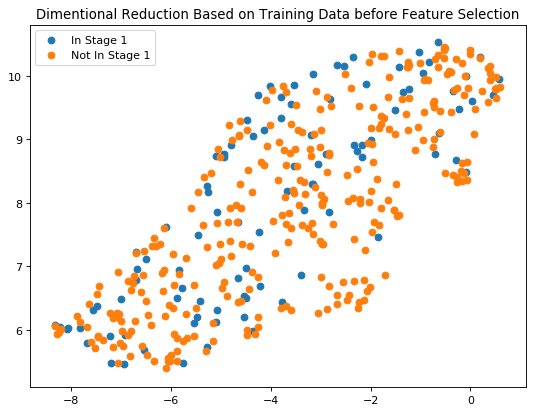

Confusion Matrix:


array([[ 1,  7],
       [ 7, 31]])

Accuracy Score:


0.6956521739130435

F1 Score:


0.8157894736842104

Feature ranking:
1. feature HCP5 (0.007160)
2. feature CRNDE (0.007020)
3. feature CD1D (0.006624)
4. feature APCDD1 (0.005921)
5. feature ERICH5 (0.005900)
6. feature HSPB8 (0.005482)
7. feature ERICH6-AS1 (0.005439)
8. feature MBOAT1 (0.005050)
9. feature RP11-15L13.4 (0.004836)
10. feature PRKAB1 (0.004743)
11. feature ZNF217 (0.004709)
12. feature SLC35F2 (0.004615)
13. feature HTR1E (0.004613)
14. feature BTN3A1 (0.004567)
15. feature APOBEC3B (0.004532)
16. feature CTSZ (0.004482)
17. feature HEBP1 (0.004409)
18. feature HSPA14 (0.004313)
19. feature GOLGA4 (0.004219)
20. feature AC079922.2 (0.004177)
21. feature ZZZ3 (0.004087)
22. feature KAZN (0.004056)
23. feature H1FX-AS1 (0.004027)
24. feature GLS2 (0.003978)
25. feature PSMB9 (0.003913)
26. feature SLC2A5 (0.003870)
27. feature PCDHB9 (0.003867)
28. feature SCPEP1 (0.003860)
29. feature PRCP (0.003801)
30. feature RP11-16E12.1 (0.003686)
31. feature ARMC4 (0.003642)
32. feature SLC45A4 (0.003641)
33. feature GNE (0.003621)

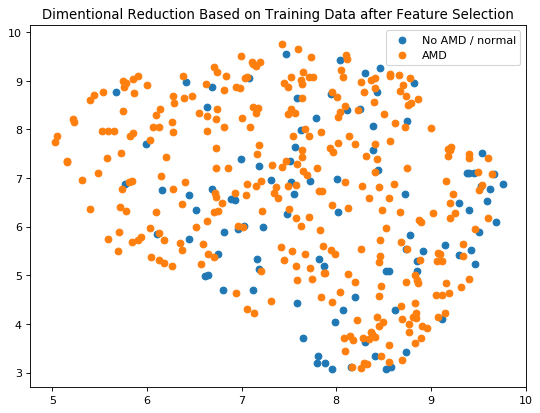

Confusion Matrix:


array([[ 0,  8],
       [ 0, 38]])

Accuracy Score:


0.8260869565217391

F1 Score:


0.9047619047619047

In [5]:
modeling(1, 100)

Before feature selection:


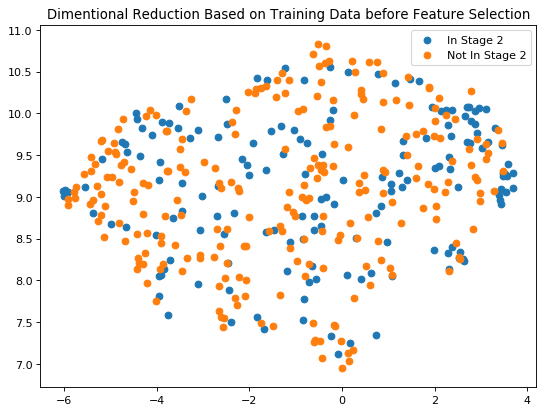

Confusion Matrix:


array([[15,  0],
       [31,  0]])

Accuracy Score:


0.32608695652173914

F1 Score:


0.0

Feature ranking:
1. feature FBXO45 (0.004871)
2. feature CTD-2553L13.10 (0.004351)
3. feature NRF1 (0.004276)
4. feature RP11-212I21.3 (0.004122)
5. feature C8orf48 (0.004056)
6. feature FNTA (0.003842)
7. feature RP11-514P8.8 (0.003786)
8. feature BCYRN1 (0.003546)
9. feature CHCHD6 (0.003529)
10. feature SPTAN1 (0.003503)
11. feature CCNYL1 (0.003490)
12. feature APCDD1L-AS1 (0.003445)
13. feature NPHP3 (0.003375)
14. feature AC093642.5 (0.003334)
15. feature RSPH14 (0.003333)
16. feature FAM109B (0.003295)
17. feature SPTLC1 (0.003291)
18. feature MEGF9 (0.003265)
19. feature BLOC1S5 (0.003214)
20. feature NAA40 (0.003186)
21. feature RP11-681B3.4 (0.003155)
22. feature RAB27A (0.003151)
23. feature KIFC3 (0.003121)
24. feature FAM151B (0.003118)
25. feature NAT16 (0.003112)
26. feature RP11-800A3.4 (0.003110)
27. feature DLGAP1-AS1 (0.003107)
28. feature ERGIC2 (0.003059)
29. feature F8 (0.003044)
30. feature ZNF383 (0.003022)
31. feature SULT4A1 (0.003005)
32. feature PADI2 (0.002

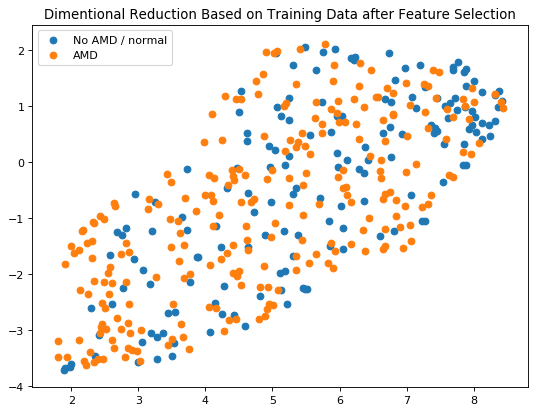

Confusion Matrix:


array([[15,  0],
       [31,  0]])

Accuracy Score:


0.32608695652173914

F1 Score:


0.0

In [6]:
modeling(2, 100)

Before feature selection:


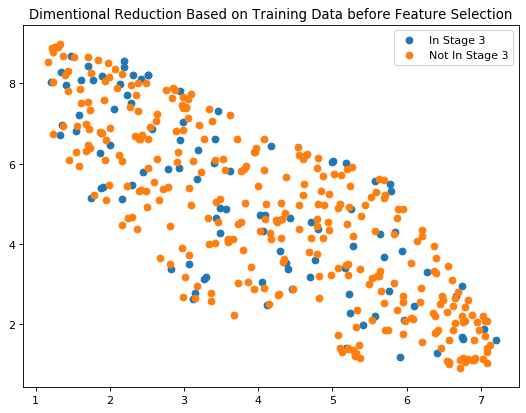

Confusion Matrix:


array([[14,  0],
       [32,  0]])

Accuracy Score:


0.30434782608695654

F1 Score:


0.0

Feature ranking:
1. feature C12orf4 (0.007376)
2. feature SCN7A (0.006368)
3. feature COX6A1 (0.006354)
4. feature CPNE4 (0.005863)
5. feature MGAT2 (0.005107)
6. feature SDCCAG8 (0.005008)
7. feature SLC12A4 (0.004897)
8. feature HHIPL2 (0.004872)
9. feature LINC01137 (0.004637)
10. feature C1orf35 (0.004548)
11. feature C1orf115 (0.004398)
12. feature RP11-415F23.4 (0.004322)
13. feature ZNF229 (0.004320)
14. feature RP11-351M8.1 (0.004280)
15. feature PURB (0.004280)
16. feature AC022007.5 (0.004200)
17. feature SNORA59B (0.004149)
18. feature C9orf142 (0.004148)
19. feature RIC1 (0.004098)
20. feature MICA (0.003931)
21. feature TMX2-CTNND1 (0.003877)
22. feature CHST15 (0.003855)
23. feature DNAJC16 (0.003848)
24. feature PTPRJ (0.003839)
25. feature SPTLC3 (0.003799)
26. feature ANO6 (0.003781)
27. feature CTU2 (0.003769)
28. feature UTP6 (0.003724)
29. feature MEIOC (0.003712)
30. feature ZNF347 (0.003583)
31. feature FAM122A (0.003549)
32. feature EXTL1 (0.003529)
33. feature T

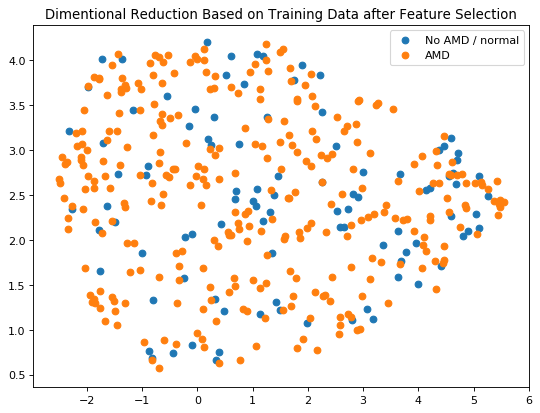

Confusion Matrix:


array([[ 0, 14],
       [ 1, 31]])

Accuracy Score:


0.6739130434782609

F1 Score:


0.8051948051948051

In [7]:
modeling(3, 100)

Before feature selection:


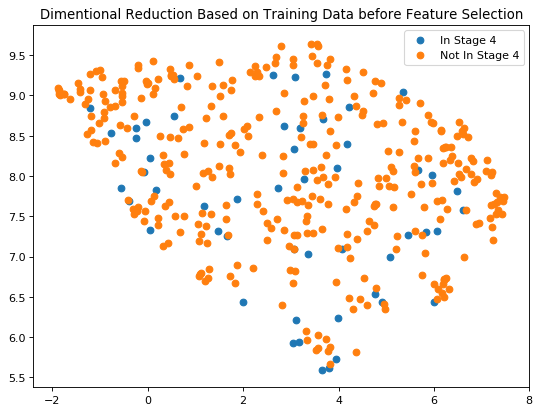

Confusion Matrix:


array([[ 0,  9],
       [ 0, 37]])

Accuracy Score:


0.8043478260869565

F1 Score:


0.891566265060241

Feature ranking:
1. feature RAE1 (0.011593)
2. feature MC4R (0.010946)
3. feature CCDC3 (0.010728)
4. feature PPP1R36 (0.010042)
5. feature RRH (0.010027)
6. feature MPZL2 (0.009686)
7. feature PDLIM5 (0.009652)
8. feature SEPT4 (0.009606)
9. feature H1F0 (0.008818)
10. feature NCKAP5 (0.008359)
11. feature SOX9 (0.008114)
12. feature SLC35D2 (0.007610)
13. feature KIF4A (0.007562)
14. feature KIAA1143 (0.007474)
15. feature CYP1B1 (0.007388)
16. feature CTD-3113P16.11 (0.007368)
17. feature ZNF570 (0.007348)
18. feature FGF1 (0.007296)
19. feature HMCES (0.007229)
20. feature TOR1AIP1 (0.007157)
21. feature SLC38A11 (0.007146)
22. feature CLYBL (0.006799)
23. feature F2R (0.006767)
24. feature TMEM9 (0.006729)
25. feature PTPRA (0.006574)
26. feature RP11-147L13.11 (0.006568)
27. feature FREM1 (0.006553)
28. feature PSMB9 (0.006423)
29. feature CYP4F12 (0.006412)
30. feature RP11-265E18.1 (0.006372)
31. feature INPP5A (0.006372)
32. feature ZNF213-AS1 (0.006316)
33. feature BABAM1 (0.

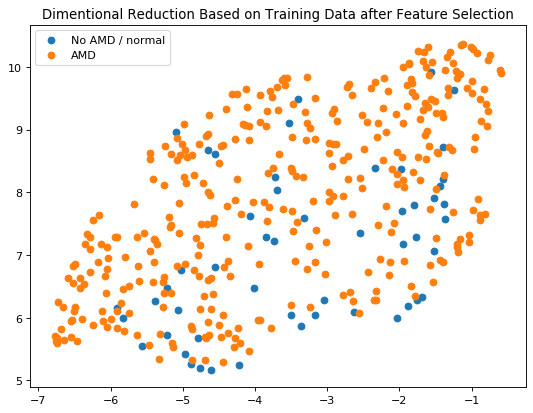

Confusion Matrix:


array([[ 0,  9],
       [ 0, 37]])

Accuracy Score:


0.8043478260869565

F1 Score:


0.891566265060241

In [8]:
modeling(4, 100)